# Introduction <br>
In this notebook I will be working with the same lead trader's data but this time it will be  the trade history.The procedure is pretty similar to the  one we used at analyzing position history but with some adaptations since the data are not similar:<br>
1.Clean the data<br>
2.Perform EDA on the trade history to identify the kind of strategy used <br>
The data scraper I used left few duplicates so I had to drop them.

### Clean the data

In [120]:
#Import required libraries
import pandas as pd
from datetime  import datetime
import matplotlib.pyplot as plt
import numpy as np

In [121]:
df_trade_history = pd.read_csv("../data/lead_trader_2m_th.csv")
df_trade_history.head()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7
0,2025-03-21 20:43:25,SUIUSDTPerp,2025-03-21 20:43:25SUIUSDTPerpClose long2.2735...,Close long,2.273500,311.2 SUI,-16.74105000 USDT
1,2025-03-21 19:47:37,1000PEPEUSDTPerp,2025-03-21 19:47:371000PEPEUSDTPerpClose long0...,Close long,0.007265,"97,649 1000PEPE",-6.10198149 USDT
2,2025-03-21 18:46:25,1000PEPEUSDTPerp,2025-03-21 18:46:251000PEPEUSDTPerpOpen long0....,Open long,0.007153,"29,543 1000PEPE",0.00000000 USDT
3,2025-03-21 12:47:54,1000PEPEUSDTPerp,2025-03-21 12:47:541000PEPEUSDTPerpOpen long0....,Open long,0.007323,"25,821 1000PEPE",0.00000000 USDT
4,2025-03-21 10:36:31,SUIUSDTPerp,2025-03-21 10:36:31SUIUSDTPerpOpen long2.28220...,Open long,2.282200,93.7 SUI,0.00000000 USDT


The data was messier than the position history so I had to soil myself a little bit.Colummn 3 is just the whole columns so I will drop it.

In [122]:
def clean_trade_history(filepath):
    #Rename cols
    df_trade_history = pd.read_csv(filepath)
    df_trade_history=df_trade_history.drop(columns= "Column3")
    df_trade_history = df_trade_history.rename(columns={
        "Column1":"Time",
        "Column2":"Symbol",
        "Column4":"Side",
        "Column5":"Price",
        "Column6": "Quantity",
        "Column7": "Realized Profit(USDT)"
    })
    df_trade_history["Realized Profit(USDT)"] = round(df_trade_history["Realized Profit(USDT)"].str.replace("USDT", "", regex=False).astype(float),2)
    df_trade_history["Quantity"]=[float(val.split()[0].replace(",","")) for val in df_trade_history["Quantity"]]
    df_trade_history["Symbol"]= df_trade_history["Symbol"].str.replace("Perp", "", regex=False)
    df_trade_history["Time"] = pd.to_datetime(df_trade_history["Time"])
    df_trade_history = df_trade_history.drop_duplicates()

    return df_trade_history

In [123]:
df_trade_history= clean_trade_history("../data/lead_trader_2m_th.csv")
df_trade_history.head()

,Time,Symbol,Side,Price,Quantity,Realized Profit(USDT)
0,2025-03-21 20:43:25,SUIUSDT,Close long,2.273500,311.2,-16.74
1,2025-03-21 19:47:37,1000PEPEUSDT,Close long,0.007265,97649.0,-6.10
2,2025-03-21 18:46:25,1000PEPEUSDT,Open long,0.007153,29543.0,0.00
3,2025-03-21 12:47:54,1000PEPEUSDT,Open long,0.007323,25821.0,0.00
4,2025-03-21 10:36:31,SUIUSDT,Open long,2.282200,93.7,0.00


In [124]:
df_trade_history.shape

(1465, 6)

In [125]:
df_trade_history.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1465 entries, 0 to 1727
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Time                   1465 non-null   datetime64[ns]
 1   Symbol                 1465 non-null   object        
 2   Side                   1465 non-null   object        
 3   Price                  1465 non-null   float64       
 4   Quantity               1465 non-null   float64       
 5   Realized Profit(USDT)  1465 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 80.1+ KB


In [126]:
df_trade_history.duplicated().sum()

0

Our data is now clean and ready for the next phase. Since we intend to take one symbol and overlay entry and exit points on its OHLC candlestick chart, we will the Symbol which was most traded.


In [127]:
most_traded = df_trade_history["Symbol"].value_counts()
most_traded

Symbol
1000PEPEUSDT    253
ONDOUSDT        231
SUIUSDT         203
FETUSDT         185
XRPUSDT         157
HBARUSDT        142
RENDERUSDT       94
ICPUSDT          82
XLMUSDT          54
DOGEUSDT         51
ALGOUSDT         13
Name: count, dtype: int64

Now we will subset our data to only return trades for 1000PEPEUSDT since it was the one with most trades during the period.

In [128]:
def PEPEUSDT_trades(Symbol):
    df_1000PEPEUSDT= df_trade_history[df_trade_history["Symbol"] == Symbol]
    return df_1000PEPEUSDT 

In [129]:
df_1000PEPEUSDT = PEPEUSDT_trades("1000PEPEUSDT")
df_1000PEPEUSDT.head(5)

,Time,Symbol,Side,Price,Quantity,Realized Profit(USDT)
1,2025-03-21 19:47:37,1000PEPEUSDT,Close long,0.007265,97649.0,-6.1
2,2025-03-21 18:46:25,1000PEPEUSDT,Open long,0.007153,29543.0,0.0
3,2025-03-21 12:47:54,1000PEPEUSDT,Open long,0.007323,25821.0,0.0
5,2025-03-21 08:07:58,1000PEPEUSDT,Open long,0.007431,22452.0,0.0
6,2025-03-21 07:17:45,1000PEPEUSDT,Open long,0.007477,19833.0,0.0


In [130]:
df_1000PEPEUSDT.shape

(253, 6)

**Merge trades that were split due to slippage** <br>
The trades that happen within the same time stamp or less than 30s are actually a single trade but have been split due to
slippage — the order was filled in chunks at slightly different prices or times, likely because there wasn’t enough liquidity 
to execute it all at once.This is common in fast-moving or less liquid markets.

In [131]:
def merge_same_timestamp_trades(df_1000PEPEUSDT):
    # df_1000PEPEUSDT = df_1000PEPEUSDT.copy()
    merged_rows = []
    i = 0
    df_1000PEPEUSDT = df_1000PEPEUSDT.sort_values("Time").reset_index(drop=True)

    while i < len(df_1000PEPEUSDT):
        current_time = df_1000PEPEUSDT.iloc[i]["Time"]
        
        # Filter rows within 30 seconds window of current_time
        same_time_rows = df_1000PEPEUSDT[
            (df_1000PEPEUSDT["Time"] >= current_time) & 
            (df_1000PEPEUSDT["Time"] <= current_time + pd.Timedelta(seconds=30))
        ]

        if len(same_time_rows) > 1:
            # Create a merged row by summing the quantities and realized profit
            merged_row = same_time_rows.iloc[0].copy()
            merged_row["Quantity"] = same_time_rows["Quantity"].sum()
            merged_row["Realized Profit(USDT)"] = same_time_rows["Realized Profit(USDT)"].sum()
            merged_rows.append(merged_row)
            
            # Skip over the rows that have been merged
            i += len(same_time_rows)
        else:
            # If there's only one row for this timestamp, append it as is
            merged_rows.append(df_1000PEPEUSDT.iloc[i])
            i += 1

    # Return the DataFrame with merged rows
    df_1000PEPEUSDT = pd.DataFrame(merged_rows).reset_index(drop=True)
    return df_1000PEPEUSDT
df_1000PEPEUSDT = merge_same_timestamp_trades(df_1000PEPEUSDT)


In [132]:
df_1000PEPEUSDT.shape

(192, 6)

**Visualizing number of open positions before closes** <br>
The lead trader appears to use an averaging down strategy, where they open multiple buy positions at lower and lower prices after the market drops. This reduces their average entry price, aiming to profit from even a small bounce back up.It is clear that the highest number of average down was 9 (after the first open) but it only occurred once. Most trades are closed between first open and the second average down.

In [133]:
# Initialize variables
trade_counts_before_close = []
current_open_trades = []

# Iterate through the trades in the DataFrame
for row in df_1000PEPEUSDT.itertuples():
    if row.Side == "Open long":
        current_open_trades.append(row)  # Keep track of open trades
    elif row.Side == "Close long" and current_open_trades:
        trade_counts_before_close.append(len(current_open_trades))  # Record the count of trades before this close
        current_open_trades = []  # Reset the list for the next group

# Create a DataFrame for the trade counts
trade_counts_df = pd.DataFrame(trade_counts_before_close, columns=["Number of Opens before Close"])
trade_counts_df = trade_counts_df["Number of Opens before Close"].value_counts().reset_index()
trade_counts_df.columns = ["Number of Opens before Close", "Frequency"]
trade_counts_df = trade_counts_df.sort_values(by="Number of Opens before Close")
trade_counts_df = trade_counts_df.set_index("Number of Opens before Close")
trade_counts_df


,Frequency
Number of Opens before Close,
1,6
2,12
3,10
4,5
5,3
6,2
7,1
8,3
9,1


In [134]:
# Summary statistics
max_trades = trade_counts_df["Frequency"].max() 
min_trades = trade_counts_df["Frequency"].min() 
print(f"Maximum number of trades before a close: {max_trades}")
print(f"Minimum number of trades before a close: {min_trades}")

Maximum number of trades before a close: 12
Minimum number of trades before a close: 1


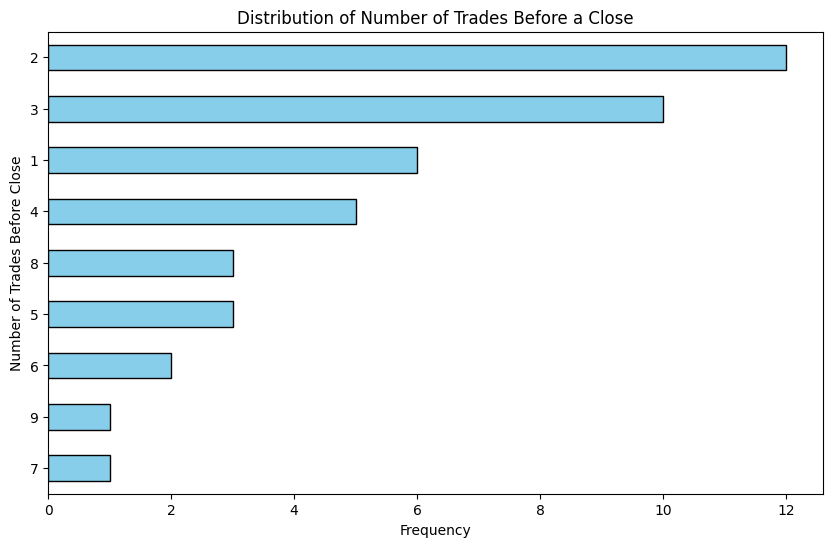

In [139]:
# Plotting the distribution of trade counts before a close using a horizontal bar plot
plt.figure(figsize=(10, 6))
trade_counts_df.sort_values("Frequency", ascending=True)["Frequency"].plot(kind='barh', color='skyblue', edgecolor='black')
plt.xlabel("Frequency")
plt.ylabel("Number of Trades Before Close")
plt.title("Distribution of Number of Trades Before a Close")
plt.show()
